We will practice to get a first taste of DL on a fake dataset evaluating gem stones based off two features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../DATA/fake_reg.csv')

In [3]:
df.head()

,price,feature1,feature2
0,461.527929,999.787558,999.766096
1,548.130011,998.861615,1001.042403
2,410.297162,1000.070267,998.844015
3,540.382220,999.952251,1000.440940
4,546.024553,1000.446011,1000.338531


Some standard EDA:

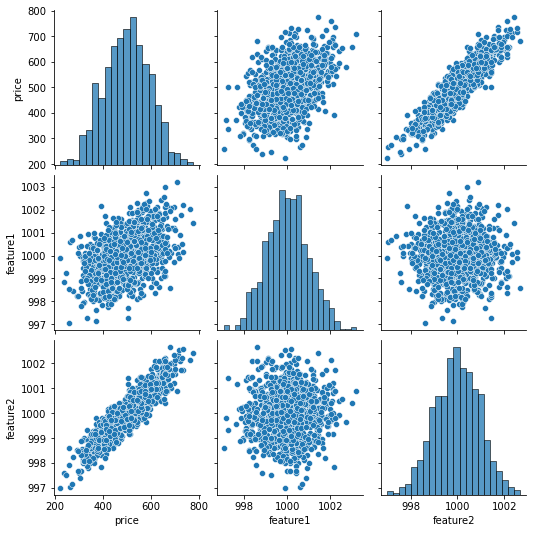

In [4]:
sns.pairplot(df)

from which we notice that the second feature seems to be well corrlated with the price

In [5]:
df.corr()

,price,feature1,feature2
price,1.000000,0.444190,0.907576
feature1,0.444190,1.000000,0.030607
feature2,0.907576,0.030607,1.000000


Let's split our data set to create train/test sets:

In [6]:
from sklearn.model_selection import train_test_split

Now: Keras wants NumPy arrays, not DataFrames, so we first have to turn our X and y into np.arrays

In [7]:
X = df.drop(['price'],axis=1)
X = np.array(X)

We use an equivalent to turn our y into an array:

In [8]:
y = df['price'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

We first scale our data, in order to not making weight and biases suffer from high values of data.
In order to do this we'll use a scaler, which we'll fit *only* with X_train.
That is: the parameters upon which the data transformation will happen -like max/min/std- are computed only on the training set, since the model is constructed based off these data.
Using X_test would be cheating: the new data are unknown by definition (thus in particular X_test, since it is just an instance of some new -and thus unknown- data, on which we will test the model build with the training set).

Then we proceed with the actual data transformation. Of course all the data have to be scaled: the training set, the test set and new data as well. In fact the model is built on the scaled X_train, hence it is supposed to receive scaled data (and scaled the same way we scaled the X_train).

One last note: it's pointless to scale the labels, they don't occur in the model's building (in particular they don't deal with weight and bias).
We just need them in the validation process, to understand how good the model is.

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

In [12]:
scaler.fit(X_train)

MinMaxScaler()

In [13]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Let's create now an Artificial Neural Network model. We start from some imports:

In [14]:
import tensorflow as tf

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

The *Sequential* model is a basic ANN model in which the layers are sequentially connected, meaning that the first layer is connected with second, the second with the third and so on.

Inside this sequential model we create layers *densely* connected, meaning that the outputs of neurons in the $i$-th layer feed *all* the neurons of the $i+1$-th layer.
For each layer we have to specify the number of neurons and a suitable activation function to “reshape” the outputs to be fed into the following layer. It is usually a good choice the *rectified linear unit*, denoted as 'relu', for the input and the hidden layers. For the output layer, the number of neurons and the choice of the activation function clealy depend on the problem: the number of neurons depends on the number of classes. In this case we want to predict a price, so we have just one neuron in the outpul layer.

Then, if we are dealing with a regression problem (that is: we want to predict some continuous label, like in this example), then we need **NOT** to reshape/modify our output. We want it as it is, so we omit the activation function.

Differently, if we are dealing with a classification problem, it works as follows:

-binary classification: a good choice is the sigmoid (aka logistic function) defined by $\phi(z)=\frac1{1+e^{-z}}$, which smoothly rescales all my values in the range $[0,1]$; then the threshold is usally 0.5: below 0.5 we get 0 and above we get 1.

-non exclusive multi class problem: the sigmoid works fine too.

-exclusive multiclass pb: we use the so-called *softmax function*, which interprets the output as a distribution of probability: if we have $N$ different classes (which is $N$ neurons in the outpul layer), then the raw output is an element $X=(x_1,\dots,x_N)\in\Bbb R^N$; so the $i$-th output of the softmax (which is then $\sigma:\Bbb R^N\to[0,1]^N$) is
$$
\sigma(X)_i=\frac{e^{x_i}}{\sum_{j=1}^{N}e^{x_j}}
$$
allowing basically the largest value among the entries of $X$ to be the winner.


Then, since we want to predict a price for gems it is a regression-like model, which has just one class in the end: that is, just one neuron in the last layer.

Finally we compile the model in order give instructions on the optimizer (which decides which kind of algorithm to use in the gradient descent) and the loss function, to compute the overall error at the end of each *epoch* (one pass through the whole dataset), allowing to optimize the choice of w/b at the next epoch.

Here is the model:

In [16]:
model = Sequential()

model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))



model.add(Dense(1))

model.compile( optimizer = 'rmsprop' , loss='mse')

The *optimizer* affects the performace of the Gradient Descent process; now we are using *rmsprop*, but in general the best known so far is *Adam*.
 

The *loss functions*  computes, at each epoch, how far the model is wrt to the true labels (everything inside the training set, of course). Then, this information is exploited, via gradient descend, to update W/B; then the model is run again (that is the following epoch) and the scheme is repeated.

Good choices for the loss functions, according to the particular model needed, are:

$\bullet$ Multi-class classification problem $\rightarrow$ loss = 'categorical_crossentropy'

$\bullet$ Binary classification problem $\rightarrow$ loss = 'binary_crossentropy'

$\bullet$ Regression problems $\rightarrow$ loss = 'mse'

In [17]:
model.fit(X_train,y_train,epochs=250, verbose=0)

Putting verbose=1 some of the info at each epochs will be shown; in particular the cost found at each epoch, even if it is contained in the following dictionary:

In [18]:
d = model.history.history

I can turn this dictionary into a df and then plot it:

In [19]:
loss_df = pd.DataFrame(d)
loss_df.head()

,loss
0,256674.531250
1,256568.187500
2,256452.828125
3,256317.296875
4,256157.250000


<AxesSubplot:>

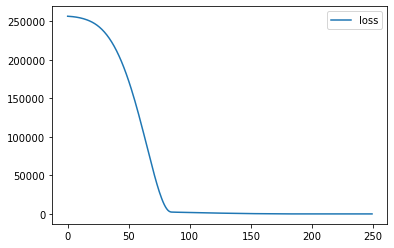

In [20]:
loss_df.plot()

Alternatively, I can get a plot as follows:

Text(0.5, 1.0, 'Training loss per epoch')

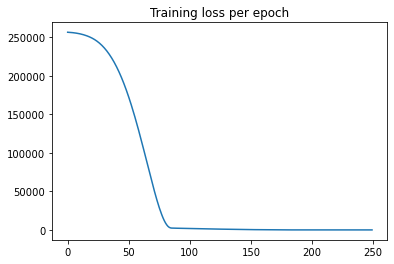

In [21]:
sns.lineplot(x=range(len(d['loss'])),y=d['loss'])
plt.title('Training loss per epoch')

And see that -typical in NN training- the loss is initially high, then collapses. Moreover it is clear that starting from around 80, we our gain stops to be relevant, thus the subsequent epoch are useless.

Let’s now evaluate our model.

In [22]:
training_score=model.evaluate(X_train,y_train)

test_score=model.evaluate(X_test,y_test)

10/10 [==============================] - 0s 313us/step - loss: 26.6970


In [40]:
print('The loss of the model on the training data is {}'.format(training_score))
print('\n')
print('The loss of the model on the test data is {}'.format(test_score))

The loss of the model on the training data is 24.49530601501465


The loss of the model on the test data is 26.697038650512695


The command model.evaluate computes automatically the MSE between the known and predicted labels; later we will compute it manually and we can check the number match.


Further evaluations can be done:

In [24]:
pred_df = pd.DataFrame(y_test,columns=['test Y'])

test_pred = model.predict(X_test)

test_pred.shape

(300, 1)

So test_pred is a $2$-dim. array $300\times 1$; we want to turn it into a Series, so we need to reshape it as a $1$-dim array:

In [25]:
test_pred = pd.Series (test_pred.reshape(300,))

In [26]:
test_pred.shape

(300,)

In [27]:
pred_df = pd.concat([pred_df , test_pred] , axis=1)

pred_df.columns = ['test Y' , 'Model Prediction']

pred_df.head()

,test Y,Model Prediction
0,402.296319,406.228668
1,624.156198,625.044373
2,582.455066,593.563538
3,578.588606,573.578979
4,371.224104,367.418854


Let’s compare the two columns of this data frame:

<AxesSubplot:xlabel='test Y', ylabel='Model Prediction'>

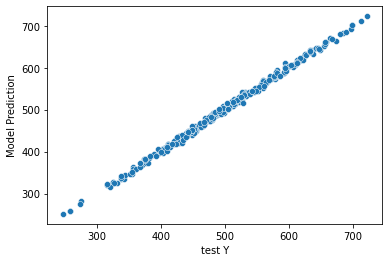

In [28]:
sns.scatterplot(x='test Y', y= 'Model Prediction', data=pred_df)

Which shows that the model predicts extremely well.

Another way to evaluate the model is as follows:

<AxesSubplot:ylabel='Count'>

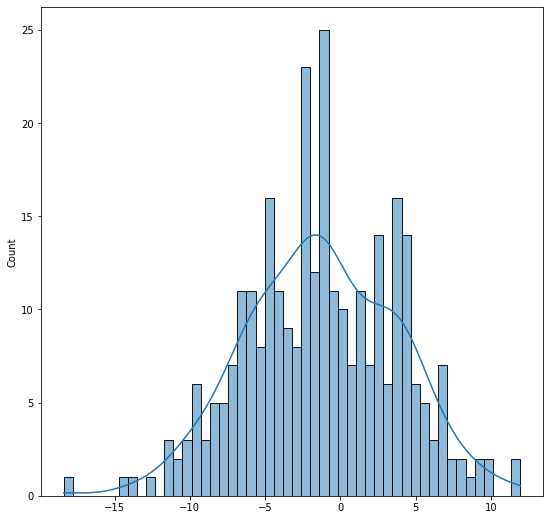

In [29]:
plt.figure(figsize=(9,9))
sns.histplot(pred_df['test Y']-pred_df['Model Prediction'], kde=True, bins=50)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

MAE = mean_absolute_error (pred_df['test Y'],pred_df['Model Prediction'])

MSE = mean_squared_error (pred_df['test Y'],pred_df['Model Prediction'])

RMSE=MSE**0.5

In [41]:
print('Mean average error is {}'.format(MAE))
print('\n')
print('Mean squared error is {}'.format(MSE))
print('\n')
print('Root Mean squared error is {}'.format(RMSE))

Mean average error is 4.188470307005126


Mean squared error is 26.69704188507274


Root Mean squared error is 5.1669180257744305


These numbers on their own are not that meaningful; the context matters:

In [44]:
df['price'].describe()

count    1000.000000
mean      498.673029
std        93.785431
min       223.346793
25%       433.025732
50%       502.382117
75%       564.921588
max       774.407854
Name: price, dtype: float64

Hence we see, looking at the mean, that the MAE is less than $1\%$; *now* I'm allowed to claim that this model works fine!

I have found a gem on the ground, with features 998 and 1000 respectively: what will its value be?

In [32]:
newgem=[[998,1000]]

newgem=scaler.transform(newgem)

model.predict(newgem)

array([[420.6291]], dtype=float32)

Finally: I want to save this model, to recall it in the future, when I will find other gems on the ground. 

In [33]:
from tensorflow.keras.models import load_model

model.save('gem_model.h5') #creates a HDF5 file ‘my_model.h5’

In [34]:
later_model = load_model('gem_model.h5')

In [35]:
later_model.predict(newgem)

array([[420.6291]], dtype=float32)

Hence it works!